Consider the linear Schr\"odinger equation:
\begin{align}
iq_t+q_{xx}&=0, &&(x,t)\in[0,L]\times [0,T],\\
q(x,0)&=q_0(x),&&x\in[0,L].
\end{align}
with energy conserving boundary conditions
\begin{align}
	q_x(L,t)=&\beta q_x(0,t)\\
	q(L,t)=&\frac{1}{\beta} q(0,t).
\end{align}

Using the UTM we find the solution:
$$
	q(x,t)=\frac{-1}{2\pi}\left(\int_{\partial \tilde{E}^-}e^{i\lambda (x-L)-i\lambda ^2t} \frac{\zeta^-(\lambda ,t)}{\Delta(\lambda )}d \lambda +\int_{\partial \tilde{E}^+}e^{i\lambda x-i\lambda ^2t} \frac{\zeta^+(\lambda ,t)}{\Delta(\lambda )}d \lambda \right)
$$

In order to evaluate this expression we could do numerical integration but that turns out to be quite slow.  Instead we will deform back to the real line and turn integrals into sums using the residue theorem.  

(Note: it turns out that we won't need to use $\zeta^-$ because there is some symmetry in our system)

In [1]:
# dependencies
using PyPlot
using ForwardDiff: Dual, partials

In [2]:
# define constants:
L = 2pi;

As typical we'll use a hat funtion initial condition but we could certainly change that

In [3]:
# define initial condition and its Fourier transform:
#hat function IC 
function q0(x::Number)
    if L/3<x<2*L/3
         return 1.
     else
         return 0.
     end
 end

#Other IC

#Fourier Transform:
q0hat(la) = quadgk(x->(q0(x)*exp(-im*x*la)), 0, L)[1];

In [4]:
# derivative---uses ForwardDiff with some wrapping to deal with the complex number situation
function complex_diff(f, z) 
    a, b = reim(z)  
    z_dual = Dual(a, one(a)) + im * Dual(b, zero(b)) 
    
    deriv = f(z_dual)
    return partials(real(deriv), 1) + im * partials(imag(deriv), 1)
end
#dq0hat(la)=complex_diff(q0hat,la);
dq0hat(la) = quadgk(x->(-im*x*q0(x)*exp(-im*x*la)), 0, L)[1];

In [5]:
# define integrand:
Delta(la,beta) = 2.*(1+beta^2)*cos(L*la) - 4*beta;
dDelta(la,beta)=-2.*L*(1+beta^2)*sin(L*la); #first derivative - could automate like above if I wanted
zetap(la,beta) = (2.*beta-(1+beta^2)*exp(im*la*L))*q0hat(la) + (beta^2-1)*exp(-im*L*la)*q0hat(-la)

#only used when |beta|=1:
#ddDelta(la)=-4.*L^2*cos(L*la); #second derivative at |beta|=1 
#dzetap(la,beta)=complex_diff(la->zetap(la,beta),la)
#note that the following only holds for |beta|=1
dzetap(la,beta)=(2.*beta-2.*exp(1im*la*L))*dq0hat(la)+(-2.*1im*L*exp(1im*la*L))*q0hat(la)

dzetap (generic function with 1 method)

As mentioned above, integration is too slow.  Instead, we will return to the real line because we know where the poles are. 

When $|\beta|=1$ the pole is of order two, otherwise the poles are of order 1.  We take advantage of the residue theorem and use expressions for the derivative.

In [6]:
# define functions for integration
mypolecount=150; # evaluation will be done at (4* this number) + 2 poles
lzero1(beta)=[2.*m*pi/L+acos(2.*beta/(1.+beta^2))/L for m in -mypolecount:mypolecount];
lzero2(beta)=[2.*m*pi/L-acos(2.*beta/(1.+beta^2))/L for m in -mypolecount:mypolecount];
lzero(beta)=[lzero1(beta);lzero2(beta)]
order1(beta,x,t)=map(la->im*exp(im*la*x-im*la^2*t)*zetap(la,beta)/dDelta(la,beta), lzero(beta))

#the following is just for |beta|=1
lzeroO2(beta)=[2.*m*pi/L+acos(beta)/L for m in -mypolecount:mypolecount];
order2(beta,x,t)=map(la->im*exp(im*la*x-im*la^2*t)*dzetap(la,beta)/(-4.*L^2*beta), lzeroO2(beta))

function q(x,t,beta)
    if abs(beta)==1
        return sum(order2(beta,x,t))
    else
        return sum(order1(beta,x,t))
    end
end

q (generic function with 1 method)

The following function finds the $x$-location of the jumps in $q(x,t)$ by evaulating $q(x,t)$ at disjoint values of $x$ and finding when the value of $q(x,t)$ jumps by more than qtol.  Further, we have to deal with the "Gibbs like" oscillations at the jump locations.  To do this we average values which are nearby (within xtol) eachother and that averaged value is where we report the jump.

In [7]:
function jumps(beta,t)
    qtol=.05; #how much of a jump in q is actually a jump?
    xtol=.15; #how close together can jumps be?
    X = collect(0:xtol/10:L);
    Q = abs(q(X,t,beta));
    mask=[false;abs(diff(Q)).>qtol]; #have to add one false at the beginning since the diff removes one element
    pjumps=X[mask];
    #pjumps is problematic because it includes all the Gibbs type values.  
    #We need to average the x-values that are close together to estimate where the jump actually occurs.
    
    ##Run this to average any x-values where a "jump" occurs that are within xtol of eachother
    jumps=similar(pjumps)
    i=1;j=1;
    while i<=length(pjumps)
        if i==length(pjumps)
            jumps[j]=pjumps[i]
            i+=1
            j+=1
        elseif pjumps[i+1]-pjumps[i]<xtol
            jumps[j]=(pjumps[i+1]+pjumps[i])/2
            i+=2
            j+=1
        else
            jumps[j]=pjumps[i]
            i+=1
            j+=1
        end
    end
    jumps=jumps[1:j-1];
    #The following runs until all the values are averaged appropriately 
    count = 1
    while minimum(diff(jumps))<xtol && count<10
        i=1;
        j=1;
        while i<=length(jumps)
            if i==length(jumps)
                jumps[j]=jumps[i]
                i+=1
                j+=1
            elseif jumps[i+1]-jumps[i]<xtol
                jumps[j]=(jumps[i+1]+jumps[i])/2
                i+=2
                j+=1
            else
                jumps[j]=jumps[i]
                i+=1
                j+=1
            end
        end
        jumps=jumps[1:j-1]
        #println(count)
        #println(minimum(diff(jumps)))
        count+=1;
    end
    jumps
end

jumps (generic function with 1 method)

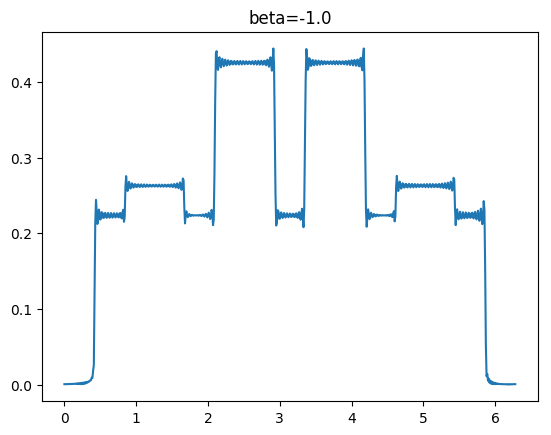

PyObject <matplotlib.text.Text object at 0x32b120650>

In [8]:
X = collect(0:.01:L)
p=1; qq=5;
T = 4*p*pi/qq;
b=-1.;
Q = abs(q(X,T,b));
plot(X,Q)
title("beta=$b")

In [ ]:
jumps(b,T)

In Olver's Dispersive Quantization paper he finds that if $t=4p \pi/q$ the jumps occur at $x=\pi j/q$ where $j\in\mathbb{Z}.$  Hence, we scale the locations of the jumps by $q/\pi$ and expect to see the jump locations at integer values

In [ ]:
bs=collect(-3:.05:3);
deleteat!(bs, findin(bs,0)) #skip 0 because there are problems evaluating here
deleteat!(bs, findin(bs,1)) #skip 1 because there are problems evaluating here
for b in bs
    j=qq/pi*jumps(b,T)
    scatter(j,b*ones(similar(j)),s=2)
end
xlabel("scaled jump location")
ylabel("value of beta")

I don't know what the problem is at $\beta=1$ but my code won't evaluate there.  Further, I could probably do work to make things happen when $\beta=0$ but it doesn't seem necessary at this point.